In [509]:
import numpy as np
import pandas as pd
import sys
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

In [510]:
# Get data
def dataIN(filename):
    return pd.read_csv(filename)

In [511]:
# Calculate average for parameter c of mutant
def get_average_c(data):
    return data.norm_velocity.mean()

In [512]:
# Calculate parameter a for mutant
def get_a_mut(a_wt, c_wt, c_mut, multiplier=1):
    # 1/v_adp_pi_depol = a_wt + c_wt
    # mutant 1/v_adp_pi_depol can be scaled differently to wt using the multiplier
    a_mut = (a_wt + c_wt)*multiplier - c_mut
    return a_mut

In [513]:
# Exponential decay function with parameters a, b and c
def expDecay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [514]:
# mutant data file with normalised velocity
filename = "/Users/roy/Documents/Manuscripts/Actin-Pi-Release/Data/Revision-1/N111S_all-data_cumulative_velocity_all-datasets.csv"

data = dataIN(filename)                     # mutant data

a_wt = 0.1696                               # wt exponential decay parameter a
c_wt = 0.1515                               # wt exponential decay parameter c

c_mut = get_average_c(data)                 # mutant exponential decay parameter c

# mutant exponential decay∏parameter a; assuming mutant v_adp_pi_depol = wt
a_mut_1 = get_a_mut(a_wt, c_wt, c_mut, 1)
# mutant exponential decay parameter a; assuming mutant v_adp_pi_depol = 2x wt
a_mut_2 = get_a_mut(a_wt, c_wt, c_mut, 0.5)

In [515]:
a_mut_1, a_mut_2, c_mut

(0.2531154628261442, 0.09256546282614421, 0.06798453717385579)

In [516]:
def plot_cost(b, cost):
    sns.lineplot(x = b, y = cost)
    plt.xlim(0, 0.3)
    # plt.ylim(0, 0.01)
    plt.title("Loss function")
    plt.xlabel("b")
    plt.ylabel(r"$\langle \sum|(yhat-y)| \rangle$")
    plt.show()

In [517]:
def optimize(data, fit_fn, a, c):
    x = data.age
    y = data.norm_velocity
    b = np.arange(0, 0.3, 0.001)
    cost = np.zeros(b.shape)

    for i, b_i in enumerate(b):
        yhat = fit_fn(x, a, b_i, c)
        cost[i] = np.sum(np.abs(yhat - y))/len(yhat)

    plot_cost(b, cost)

    return b, cost, b[np.argmin(cost)]

In [518]:
# a_mut_current = a_mut_1
a_mut_current = a_mut_2

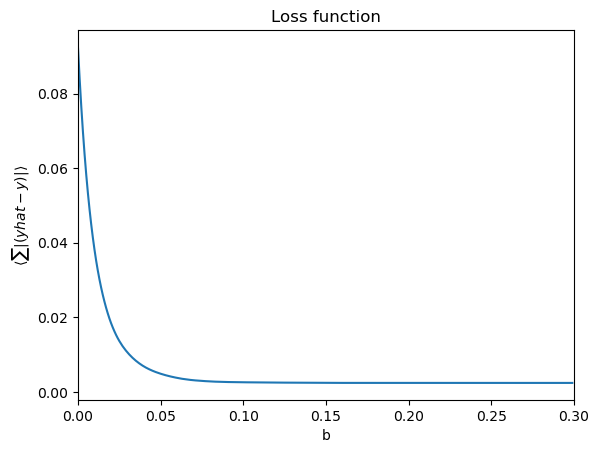

In [519]:
b, cost, b_opt = optimize(data, expDecay, a_mut_current, c_mut)

In [520]:
# Fit loss function prediction parameters
popt, pcov = curve_fit(expDecay, b, cost, bounds=(0, [1, np.inf, 0.1]))
popt, pcov

(array([8.68797900e-02, 8.52285095e+01, 2.59789438e-03]),
 array([[ 8.40583552e-08,  8.15551033e-05, -1.80159216e-10],
        [ 8.15551033e-05,  1.92232031e-01,  4.33180657e-06],
        [-1.80159216e-10,  4.33180657e-06,  1.14955618e-09]]))

In [521]:
# Max cost
max(cost)

0.0925654628261442

Text(0, 0.5, '$\\langle \\sum|(yhat-y)| \\rangle$')

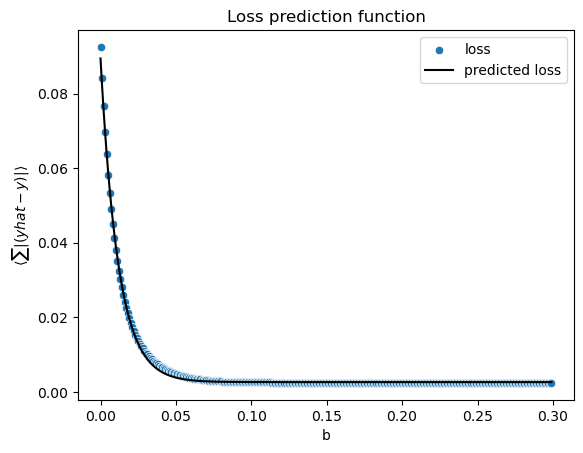

In [522]:
b_pred = b
cost_pred = expDecay(b_pred, *popt)

sns.scatterplot(x=b,
                y=cost,
                label="loss")
sns.lineplot(x=b_pred,
             y=cost_pred,
             color='black',
             label="predicted loss")
plt.title("Loss prediction function")
plt.xlabel("b")
plt.ylabel(r"$\langle \sum|(yhat-y)| \rangle$")

In [523]:
def check_b_cutoff(k, cutoff):
    return np.log(cutoff)/-k

In [524]:
tolerance = 1e-3
b_final = check_b_cutoff(popt[1], c_mut*tolerance)
b_final

0.11259413463901893

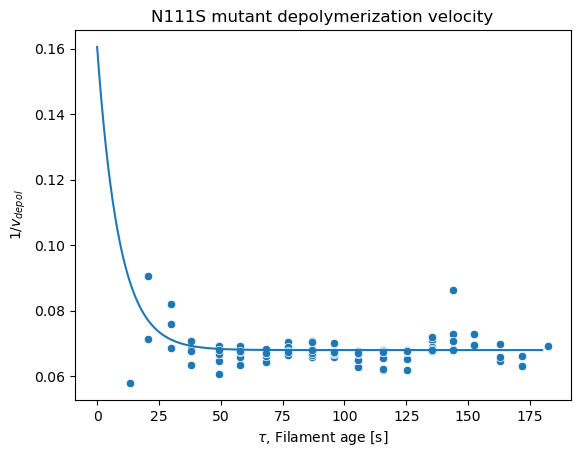

In [525]:
x_pred = np.arange(0, 180, 0.1)
y_pred = expDecay(x_pred, a_mut_current, b_final, c_mut)

sns.scatterplot(data=data,
                x="age",
                y="norm_velocity")
sns.lineplot(x=x_pred,
             y=y_pred)
plt.title("N111S mutant depolymerization velocity")
plt.xlabel(r"$\tau$, Filament age [s]")
plt.ylabel(r"$1/v_{depol}$")
plt.show()